In [1]:
import numpy as np
import os,sys


sys.path.append('../../../Env')
sys.path.append('../../../Imaging')
sys.path.append('../../../../RL_lib/Agents/PPO')
sys.path.append('../../../../RL_lib/Utils')
%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_repo/Exo_intercept/Experiments/EKV/Test_PN


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 6.123234e-17  0.000000e+00 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17]]
[1.000000e+00 0.000000e+00 6.123234e-17]
using max  pooling
Angle sensor:
	Output State type:  <function Angle_sensor.optflow_state at 0x1549f1c80>
	Offset Init type:  <function Angle_sensor.offset_init1 at 0x1549f18c8>
	Fixed Offset:  None
3dof dynamics model
3-dof Actuator Model:  49.050000000000004
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Target Model: 
 - foo:  0.0
6dof dynamics model
thruster model:  [4905. 4905. 4905. 4905.]
Rotational Velocity Constraint
Attitude Constraint
Inertia Tensor:  [[1.04166667 0.         0.        ]
 [0.         7.29166667 0.        ]
 [0.         0.         7.29166667]]
Missile Model: 
 - foo:  0.0
Reward_terminal


<IPython.core.display.Javascript object>


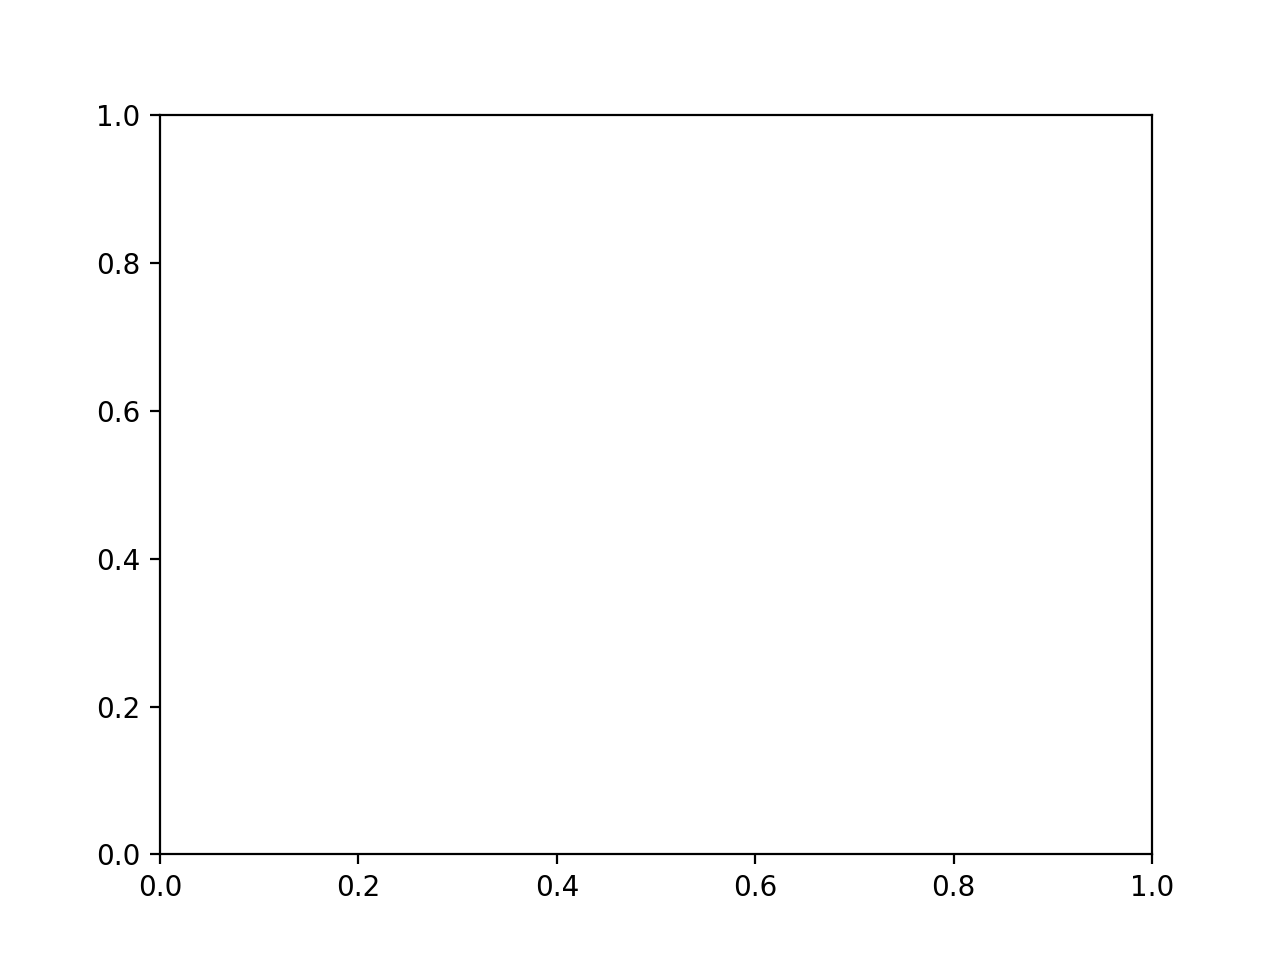

<IPython.core.display.Javascript object>


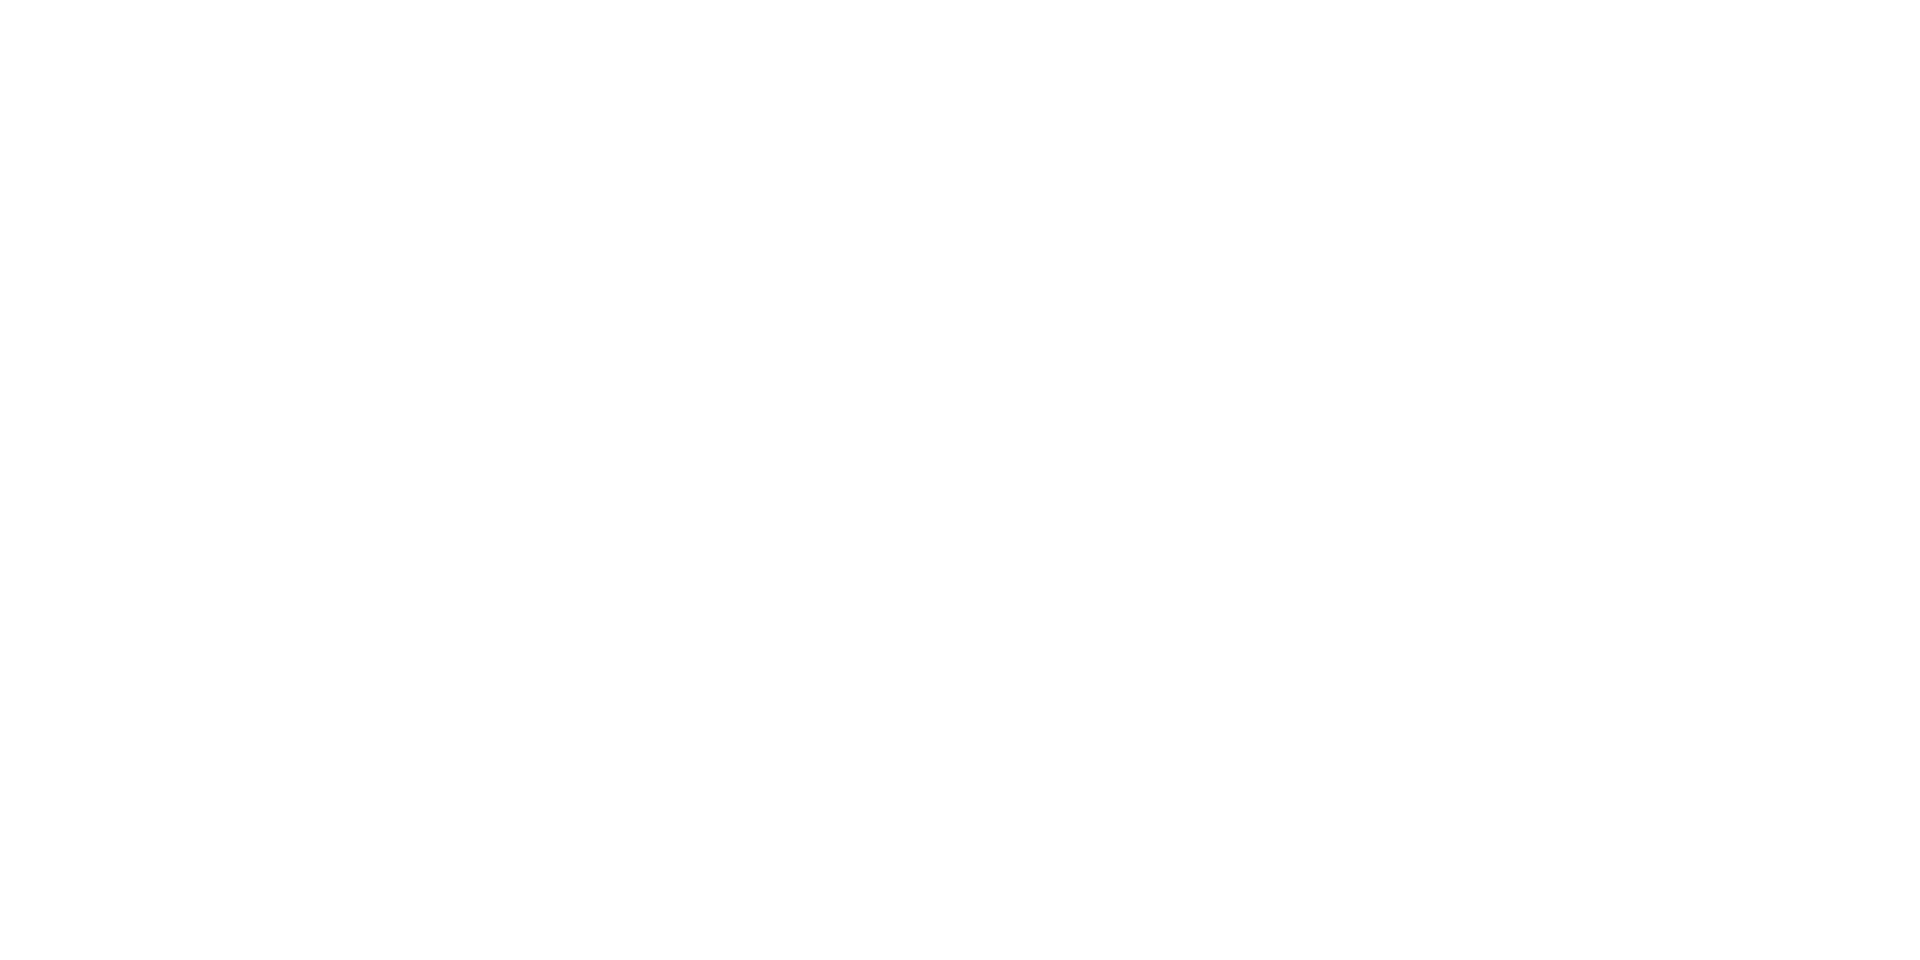

<IPython.core.display.Javascript object>


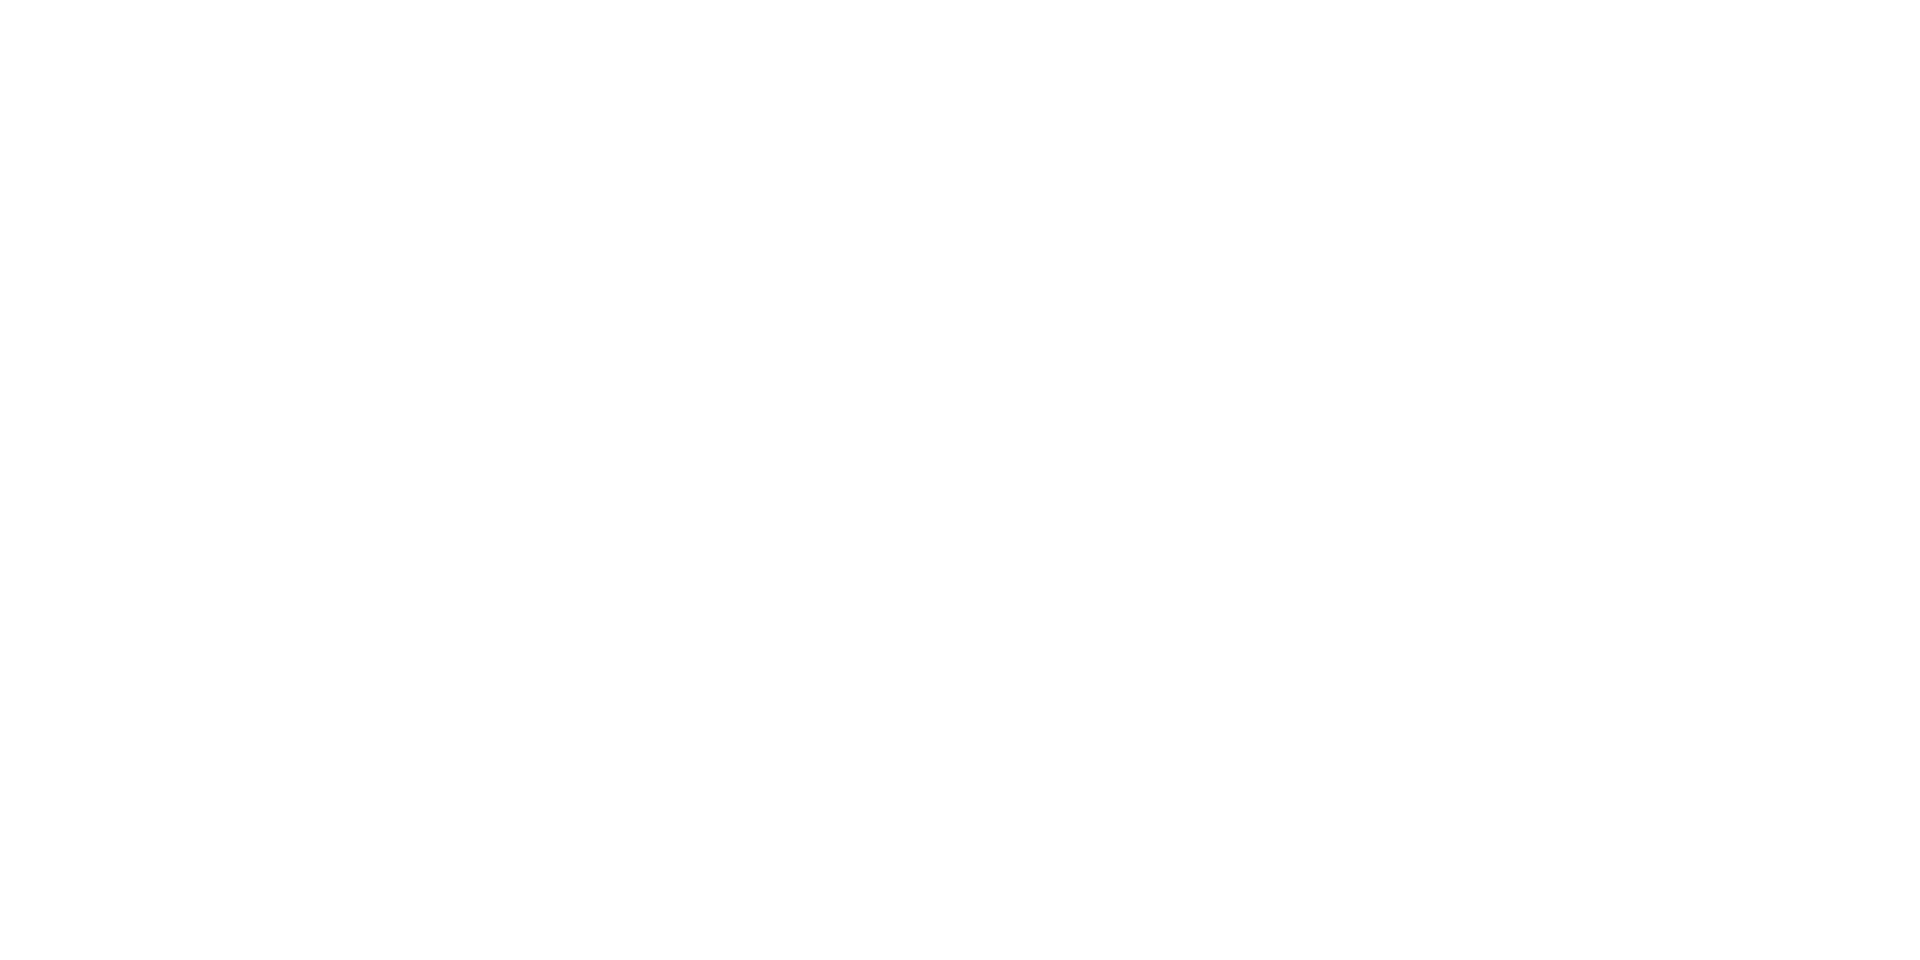

<IPython.core.display.Javascript object>


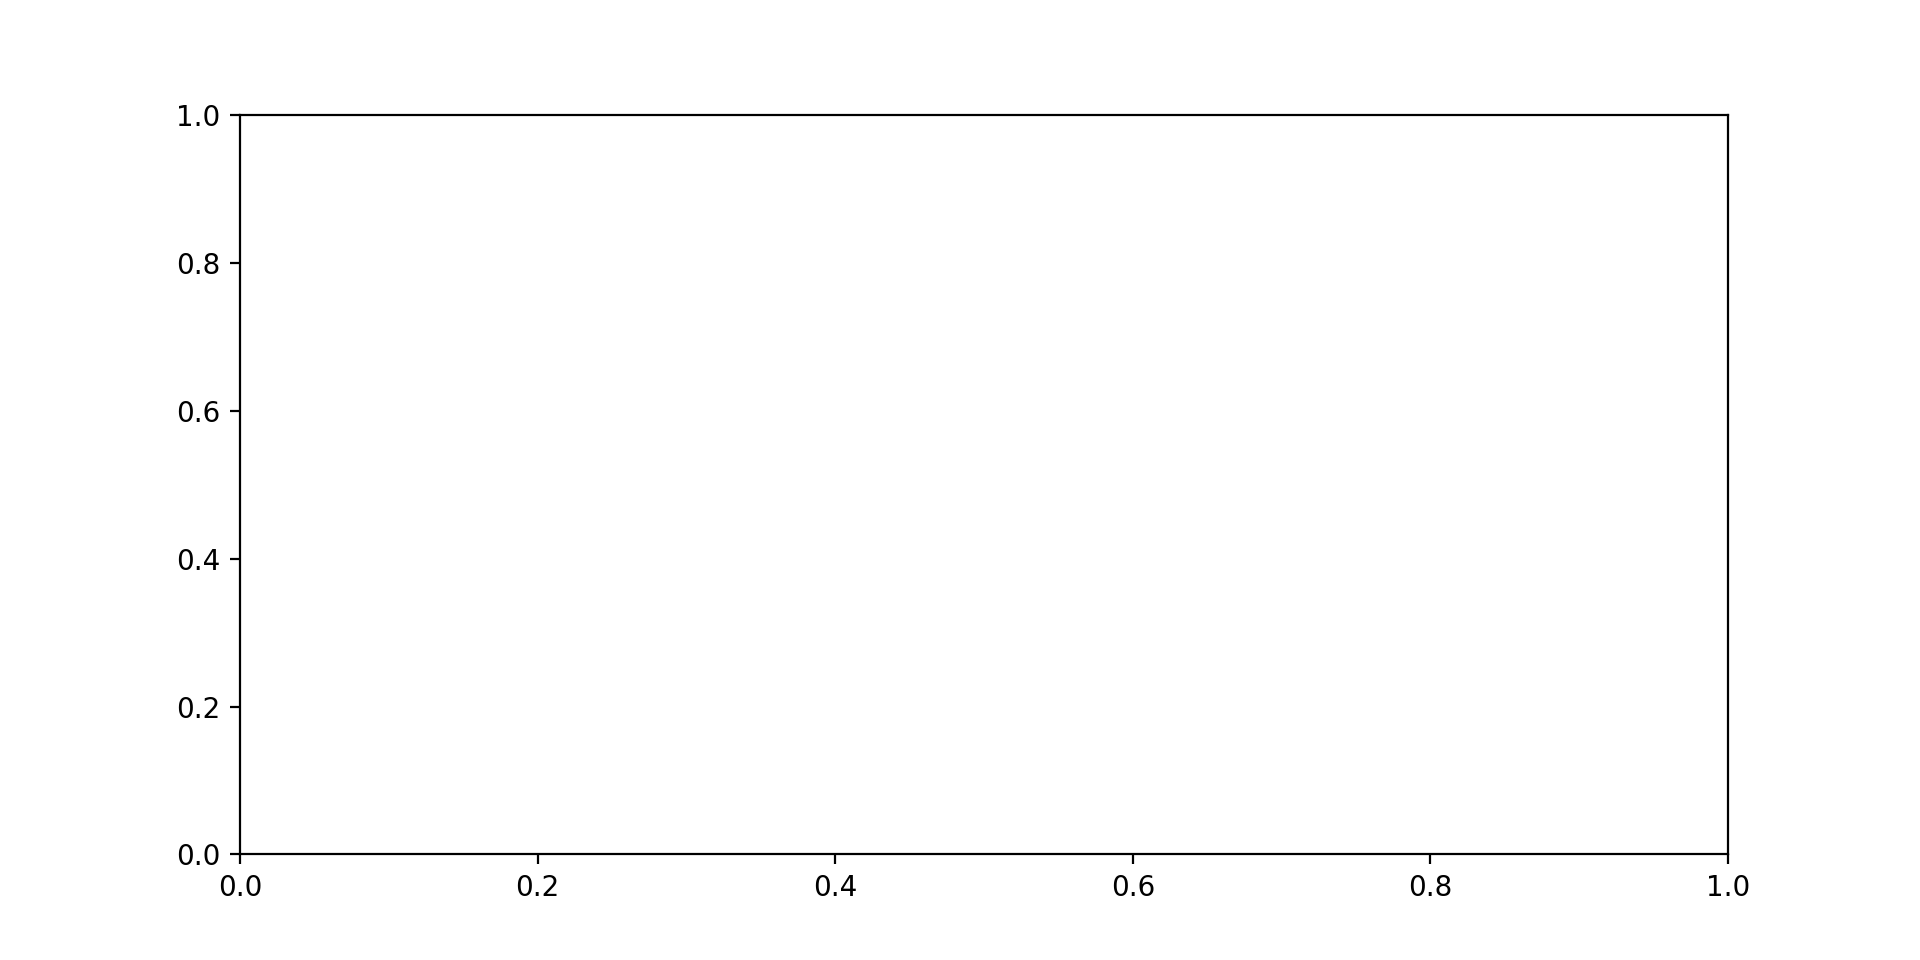

Missile env fixed (h= 0.02
Value Funtion
	xn_init: layer  Linear(in_features=19, out_features=190, bias=True)
	xn_init: layer  GRUCell(190, 30)
	xn_init: layer  Linear(in_features=30, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    200
	Rollout Limit:      1
Agent


In [3]:
from env import Env
import env_utils as envu
from reward_sensor_gaussian_of import Reward

import attitude_utils as attu

from missile import Missile
from target import Target

from missile_icgen import Missile_icgen
from target_icgen import Target_icgen

from dynamics_model_3dof import Dynamics_model_3dof as Target_dynamics_model
from dynamics_model_6dof import Dynamics_model_6dof as Missile_dynamics_model

from spiral_policy import Spiral_policy as Target_policy

from no_att_constraint import No_att_constraint
from no_w_constraint import No_w_constraint

######### RL vs PN ###########

is_RL = False

########## RL ###########

import rl_utils
from arch_policy_vf import Arch
import policy_nets as policy_nets
import valfunc_nets as vf_nets
from agent import Agent
from value_function import Value_function

if is_RL:
    from policy import Policy
    from softmax_pd import Softmax_pd as PD
else:
    from zem_policy import ZEM_policy as Policy
    
######### Actuator Models #########

from actuator_model_ekv import Actuator_model_ekv as Missile_actuator_model 
from actuator_model_3dof import Actuator_model_3dof as Target_actuator_model

######## Sensor ##############

from angle_sensor import Angle_sensor
from eo_model import EO_model
import optics_utils as optu

ap = attu.Quaternion_attitude()

offset=np.asarray([0,0])
C_cb = optu.rotate_optical_axis(0.0, np.pi/2, 0.0)
r_cb = np.asarray([0,0,0])
fov=np.pi-np.pi/8
cm = EO_model(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb, 
                   fov=fov, debug=False, p_x=96,p_y=96)
sensor = Angle_sensor(cm, attitude_parameterization=ap,  use_range=True, ignore_fov_vio=not is_RL,
                      use_ideal_offset=False,
                      pool_type='max', state_type=Angle_sensor.optflow_state, optflow_scale=0.1)


########## Target ############

target_voffset = 10
target_max_acc = 5*9.81
target_max_acc_range = (0, target_max_acc)
target_dynamics_model = Target_dynamics_model(h=0.02,M=1e3)
target_actuator_model = Target_actuator_model(max_acc=target_max_acc)
target_policy = Target_policy(3,max_acc=target_max_acc,qp_range=(5,25))
target = Target(target_policy, target_actuator_model, target_dynamics_model, attitude_parameterization=ap)

target_icgen = Target_icgen(attitude_parameterization=ap,
                            min_init_position=(0.0, 0.0, 50000.),
                            max_init_position=(0.0, 0.0, 50000.),
                            v_mag=(4000., 4000.),
                            v_theta=(envu.deg2rad(90-target_voffset), envu.deg2rad(90+target_voffset)),
                            v_phi=(envu.deg2rad(-target_voffset), envu.deg2rad(target_voffset)))

########## Missile  #############

missile_roffset = 10
missile_mass = 50
missile_max_thrust =  10*9.81*missile_mass

missile_dynamics_model = Missile_dynamics_model(h=0.02,M=1e3)

missile_actuator_model = Missile_actuator_model(max_thrust=missile_max_thrust,pulsed=True)
missile = Missile(target, missile_actuator_model, missile_dynamics_model, sensor=sensor, 
                  attitude_parameterization=ap,
                  w_constraint=No_w_constraint(), att_constraint=No_att_constraint(ap),
                 align_cv=False, debug_cv=False, perturb_pn_velocity=True)
if not is_RL:
    missile.get_state_agent = missile.get_state_agent_PN_att
    
missile_icgen = Missile_icgen(attitude_parameterization=ap,
                           position_r=(50000.,55000.),
                           position_theta=(envu.deg2rad(90-missile_roffset),envu.deg2rad(90+missile_roffset)),
                           position_phi=(envu.deg2rad(-missile_roffset),envu.deg2rad(missile_roffset)),
                           mag_v=(3000,3000),
                           heading_error=(envu.deg2rad(0),envu.deg2rad(5)),
                           attitude_error=(envu.deg2rad(0),envu.deg2rad(5)),
                           debug=False)


reward_object = Reward(debug=False, hit_coeff=10., tracking_coeff=1., tracking_sigma=0.10, optflow_sigma=0.004, 
                       fuel_coeff=0.0, fov_coeff=-0., hit_rlimit=0.5)

logger = rl_utils.Logger()

env = Env(missile, target, missile_icgen, target_icgen,  logger, 
          precision_range=1000., precision_scale=300, terminate_on_vc=not is_RL,
          reward_object=reward_object, use_offset=False, debug_steps=True,
          tf_limit=50.0,print_every=10,nav_period=0.10)

                

##########################################
recurrent_steps = 200
if is_RL:
    obs_dim = 4
    action_dim = 4
    actions_per_dim = 2
    logit_dim = action_dim * actions_per_dim
    policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
else:
    policy = Policy(ap=ap, N=3, max_acc=missile_max_thrust / missile_mass)
    obs_dim = 19
    act_dim = 4
    
arch = Arch()

value_function = Value_function(vf_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.90, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)



# Test Policy with Realistic Noise


In [4]:

env.test_policy_batch(agent,5000,print_every=100,test_mode=True)

worked 1
Dynamics: Max Disturbance (m/s^2):  [1.18624082e-12 9.67912829e-14 1.30126667e-12] 1.763471229926205e-12
Dynamics: Max Disturbance (m/s^2):  [0.0000e+00 0.0000e+00 2.6696e-12] 2.6695999999999994e-12
i (et): 100  (             230)
Cumulative Stats (mean,std,max,argmax)
thrust   |4804.23 |2325.47 |  0.00 |6936.72 |     2
 
Final Stats (mean,std,min,max)
hit_reward |     2.4 |     4.3 |     0.0 |    10.0
hit_100cm |    0.61 |    0.49 |    0.00 |    1.00
hit_50cm |    0.24 |    0.43 |    0.00 |    1.00
norm_vf  |6828.593 | 162.195 |6378.512 |7036.533
norm_rf  |     0.9 |     0.6 |     0.1 |     3.2
position | 30377.3   541.6 50494.9 |  1007.6  3205.1  2993.6 | 28355.9 -5374.1 45466.4 | 32757.3  5564.9 56713.4
velocity |-2802.605 127.572   8.661 | 163.223 807.128 719.759 |-3014.916-1447.597-1463.874 |-2245.0481735.5251493.642
fuel     | 21.84 |  3.17 | 13.10 | 30.03
attitude_321 |   0.364   0.014   0.362 |   2.873   0.260   1.561 |  -3.137  -0.462  -2.820 |   3.138   0.651   3.123

Dynamics: Max Disturbance (m/s^2):  [1.58963892e-12 2.66851290e-13 2.09823622e-12] 2.6458943184179577e-12
Dynamics: Max Disturbance (m/s^2):  [1.42031535e-12 2.40203770e-13 2.68854543e-12] 3.0501262371334195e-12
i (et): 900  (             234)
Cumulative Stats (mean,std,max,argmax)
thrust   |4778.08 |2351.60 |  0.00 |6936.72 |     2
 
Final Stats (mean,std,min,max)
hit_reward |     2.2 |     4.1 |     0.0 |    10.0
hit_100cm |    0.60 |    0.49 |    0.00 |    1.00
hit_50cm |    0.22 |    0.41 |    0.00 |    1.00
norm_vf  |6822.943 | 155.186 |6130.020 |7046.222
norm_rf  |     1.1 |     2.4 |     0.1 |    70.0
position | 30468.7    88.3 50488.7 |  1073.0  3163.9  3050.0 | 28222.6 -5618.3 44815.4 | 34197.6  6032.5 56713.4
velocity |-2795.175  -3.989  44.989 | 166.406 805.769 752.118 |-3041.132-1760.084-1752.554 |-2133.5961758.2421789.935
fuel     | 21.79 |  3.30 | 12.44 | 33.55
attitude_321 |   0.045   0.000   0.014 |   2.906   0.261   1.722 |  -3.141  -0.712  -3.140 |   3.141   0.679   3

Dynamics: Max Disturbance (m/s^2):  [1.58963892e-12 2.67685117e-13 2.09823622e-12] 2.6459785439610185e-12
Dynamics: Max Disturbance (m/s^2):  [1.42976927e-12 2.40203770e-13 2.68861371e-12] 3.0546000861636376e-12
i (et): 1700  (             236)
Cumulative Stats (mean,std,max,argmax)
thrust   |4771.73 |2356.76 |  0.00 |6936.72 |  1205
 
Final Stats (mean,std,min,max)
hit_reward |     2.0 |     4.0 |     0.0 |    10.0
hit_100cm |    0.57 |    0.49 |    0.00 |    1.00
hit_50cm |    0.20 |    0.40 |    0.00 |    1.00
norm_vf  |6820.202 | 159.370 |6130.020 |7046.222
norm_rf  |     1.0 |     1.8 |     0.1 |    70.0
position | 30509.9    75.3 50485.2 |  1075.8  3121.4  3067.4 | 28027.0 -5634.2 44469.5 | 34387.8  6032.5 56713.4
velocity |-2792.245   7.604  34.693 | 171.185 800.792 768.572 |-3050.330-1772.179-1830.708 |-2131.0151822.8751856.591
fuel     | 21.79 |  3.30 | 12.09 | 33.55
attitude_321 |   0.056   0.005  -0.041 |   2.906   0.267   1.747 |  -3.141  -0.712  -3.140 |   3.141   0.679   

Dynamics: Max Disturbance (m/s^2):  [1.58963892e-12 2.67685117e-13 2.09823622e-12] 2.6459785439610185e-12
Dynamics: Max Disturbance (m/s^2):  [1.42976927e-12 2.41368679e-13 2.68861371e-12] 3.054691911574924e-12
i (et): 2500  (             233)
Cumulative Stats (mean,std,max,argmax)
thrust   |4757.05 |2358.08 |  0.00 |6936.72 |  1205
 
Final Stats (mean,std,min,max)
hit_reward |     2.0 |     4.0 |     0.0 |    10.0
hit_100cm |    0.58 |    0.49 |    0.00 |    1.00
hit_50cm |    0.20 |    0.40 |    0.00 |    1.00
norm_vf  |6819.699 | 161.342 |6129.031 |7046.222
norm_rf  |     1.0 |     1.5 |     0.1 |    70.0
position | 30531.0    89.5 50527.5 |  1075.0  3127.8  3097.9 | 28027.0 -5697.7 44469.5 | 34387.8  6032.5 56713.4
velocity |-2791.649  16.023  35.102 | 173.122 790.102 781.719 |-3065.948-1855.154-1830.708 |-2033.5021822.8751856.591
fuel     | 21.70 |  3.27 | 12.09 | 33.55
attitude_321 |   0.058   0.003  -0.025 |   2.909   0.273   1.769 |  -3.142  -0.712  -3.140 |   3.141   0.726   3

Dynamics: Max Disturbance (m/s^2):  [1.58963892e-12 2.67685117e-13 2.09823622e-12] 2.6459785439610185e-12
Dynamics: Max Disturbance (m/s^2):  [1.42976927e-12 2.42432201e-13 2.68865390e-12] 3.054811502463187e-12
i (et): 3300  (             224)
Cumulative Stats (mean,std,max,argmax)
thrust   |4756.29 |2362.77 |  0.00 |6936.72 |  1205
 
Final Stats (mean,std,min,max)
hit_reward |     1.9 |     4.0 |     0.0 |    10.0
hit_100cm |    0.58 |    0.49 |    0.00 |    1.00
hit_50cm |    0.19 |    0.40 |    0.00 |    1.00
norm_vf  |6819.517 | 162.887 |6066.177 |7051.123
norm_rf  |     1.0 |     1.3 |     0.0 |    70.0
position | 30527.4    71.5 50496.0 |  1080.4  3126.1  3103.6 | 27796.9 -5703.1 44469.5 | 34441.7  6032.5 56713.4
velocity |-2791.340  -1.151  32.340 | 174.877 788.950 783.966 |-3065.948-1855.154-1830.708 |-2033.5021822.8751856.591
fuel     | 21.71 |  3.25 | 12.09 | 33.55
attitude_321 |   0.039   0.005  -0.023 |   2.910   0.274   1.775 |  -3.142  -0.712  -3.140 |   3.141   0.726   3

Dynamics: Max Disturbance (m/s^2):  [1.58963892e-12 2.73549698e-13 2.09823622e-12] 2.6465782759566716e-12
Dynamics: Max Disturbance (m/s^2):  [1.42976927e-12 2.50382421e-13 2.68889474e-12] 3.055664644853289e-12
i (et): 4100  (             218)
Cumulative Stats (mean,std,max,argmax)
thrust   |4756.33 |2359.61 |  0.00 |6936.72 |  1205
 
Final Stats (mean,std,min,max)
hit_reward |     1.9 |     3.9 |     0.0 |    10.0
hit_100cm |    0.58 |    0.49 |    0.00 |    1.00
hit_50cm |    0.19 |    0.39 |    0.00 |    1.00
norm_vf  |6819.138 | 164.045 |6066.177 |7051.123
norm_rf  |     1.0 |     1.2 |     0.0 |    70.0
position | 30533.7    72.8 50520.6 |  1084.5  3129.4  3113.4 | 27796.9 -5858.6 44469.5 | 34441.7  6032.5 56713.4
velocity |-2790.873  -1.454  44.238 | 175.659 782.295 791.852 |-3065.948-1855.154-1830.708 |-2017.7991822.8751960.288
fuel     | 21.71 |  3.22 | 12.08 | 33.55
attitude_321 |   0.039  -0.000  -0.026 |   2.911   0.276   1.782 |  -3.142  -0.712  -3.141 |   3.141   0.726   3

i (et): 4900  (             223)
Cumulative Stats (mean,std,max,argmax)
thrust   |4763.73 |2354.91 |  0.00 |6936.72 |  1205
 
Final Stats (mean,std,min,max)
hit_reward |     2.0 |     4.0 |     0.0 |    10.0
hit_100cm |    0.58 |    0.49 |    0.00 |    1.00
hit_50cm |    0.20 |    0.40 |    0.00 |    1.00
norm_vf  |6821.959 | 162.256 |6066.177 |7055.443
norm_rf  |     1.0 |     1.2 |     0.0 |    70.0
position | 30529.7    55.4 50524.0 |  1084.8  3124.6  3109.3 | 27796.9 -5858.6 44407.1 | 34441.7  6034.2 56713.4
velocity |-2793.923  -5.490  47.665 | 173.817 776.633 787.010 |-3067.897-1855.154-1830.708 |-2017.7991822.8751960.288
fuel     | 21.74 |  3.21 | 12.08 | 33.55
attitude_321 |   0.021  -0.002  -0.016 |   2.913   0.274   1.782 |  -3.142  -0.712  -3.141 |   3.141   0.726   3.142
w        |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000
Dynamics: Max Disturbance (m/s^2):  [1.58963892e-12 2.73568157e-13 2.11159819e-12] 2.65718616